In [1]:
import os
import pickle
import numpy as np
import pandas as pd

# Load the data

In [2]:
base = '/mnt/e/Ronniek/barak-graph'

with open(os.path.join(base, 'atlas_meta.pkl'), 'rb') as f:
    atlas_meta = pickle.load(f)

with open(os.path.join(base, 'mat_index_to_label.pkl'), 'rb') as f:
    mat_index_to_label = pickle.load(f)

#with open(os.path.join(base, 'mat.pkl'), 'rb') as f:
#    mat = pickle.load(f)
mat = np.load(os.path.join(base, 't_mat.npy'))

networks = ['AN', 'Vis', 'SMN', 'DMN', 'FPN']
network = networks[0]

Filter the labels from the atlas to only have region with a valid hemisphere (some regions have a number instead of a hemisphere).

In [3]:
labels = [
    label for label, region in atlas_meta.iterrows()
    if region.Hemi in ('R', 'L') and region.SubNetwork == network
]

The original mat_index_to_label is a numpy array (instead of a dict), and has floating point values instead of integers (so we can't use them when indexing). Convert to a dict with integers.

In [4]:
mat_index_to_label = {
    index: int(label) for index, label in enumerate(mat_index_to_label)
}

And create a reverse mapping from label to matrix index

In [5]:
def region_by_label(i):
    return atlas_meta.loc[i]  # Labels are strings in the atlas

def reverse_dict(d):
    return {v: k for k, v in d.items()}

label_to_mat_index = reverse_dict(mat_index_to_label)

# Sanity
assert mat_index_to_label[label_to_mat_index[25]]

# Ordering

Create a key for each region (based on hemi + lobe + gyrus + description), and make sure that for each region we have another region with the same key with the hemisphere value swapped.

In [6]:
# Make sure that for every region we have an identical region in the other hemisphere

def region_key(region):
    return (region.Hemi, region.Lobe, region.Gyrus, region.description)

def enumerate_regions(labels):
    for label in labels:
        yield label, region_by_label(label)

region_keys = {
    region_key(region) for label, region in enumerate_regions(labels)
}

# Make sure all keys are unique
assert len(region_keys) == len(labels)

# Make sure every key has a corresponding key in the other hemisphere
for key in region_keys:
    key_edit = list(key)
    key_edit[0] = {'L': 'R', 'R': 'L'}[key_edit[0]]
    key_edit = tuple(key_edit)
    assert key_edit in region_keys

AssertionError: 

Lobes have afixed order from front to back:

In [7]:
LOBE_ORDER = reversed([   
    'Frontal Lobe',
    'Parietal Lobe',
    'Insular Lobe',
    'Temporal Lobe',
    'Occipital Lobe',
    'Limbic Lobe',
    'Subcortical Nuclei',
])
LOBE_TO_INDEX = {
    lobe: i for i, lobe in enumerate(LOBE_ORDER)
}

Gyri and region (description) are sorted by the order in which the appear in the input atlas:

In [8]:
GYRUS_REGION_ORDER = []
for label, region in enumerate_regions(labels):
    key = (region.Gyrus, region.description)
    if key not in GYRUS_REGION_ORDER:
        GYRUS_REGION_ORDER.append(key)
GYRUS_REGION_ORDER = {
    key: i for i, key in enumerate(GYRUS_REGION_ORDER)
}

To have mirror sorting between the hemispheres in the graph:
1. Find the index numbers for lobes and gyros+region
2. For the left hemisphere multiply all numbers by -1 (which will mean large values on the right hemisphere will be small on the left hemisphere)

In [9]:
def region_sort_key(region):
    multiple = {'L': -1, 'R': +1}[region.Hemi]
    # Add +1 to indices, so that we don't have an equality when multipleying
    # 0 by -1 and +1
    lobe_idx = 1 + LOBE_TO_INDEX[region.Lobe.strip()]
    gyrus_region_idx = 1 + GYRUS_REGION_ORDER[(region.Gyrus, region.description)]
    return (multiple, lobe_idx * multiple, gyrus_region_idx * multiple)

In [10]:
sorted_labels = sorted(labels, key=lambda label: region_sort_key(region_by_label(label)))
label_to_sort_index = {
    label: index for index, label in enumerate(sorted_labels)
}

Test by eye that this makes sense - take the first and last 3:

In [11]:
atlas_meta.loc[sorted_labels[:3] + sorted_labels[-3:]]

,Unnamed: 0,ROIname,Lobe,Gyrus,description,SubNetwork,Hemi
Label,,,,,,,
67,66,A4ll_L,Frontal Lobe,"PCL, Paracentral Lobule",area 4,AN,L
63,62,A6cvl_L,Frontal Lobe,"PrG, Precentral Gyrus",caudal ventrolateral area 6,AN,L
61,60,A4tl_L,Frontal Lobe,"PrG, Precentral Gyrus",area 4(tongue and larynx region),AN,L
62,61,A4tl_R,Frontal Lobe,"PrG, Precentral Gyrus",area 4(tongue and larynx region),AN,R
64,63,A6cvl_R,Frontal Lobe,"PrG, Precentral Gyrus",caudal ventrolateral area 6,AN,R
68,67,A4ll_R,Frontal Lobe,"PCL, Paracentral Lobule",area 4,AN,R


# Built in drawing

In [12]:
import nxviz as nv
import nxviz.annotate as nva
import networkx as nx
import itertools
import matplotlib.pyplot as plt


/home/ronniek/Development/venv-comis/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.0, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Build the graph

In [13]:
G = nx.Graph(directed=False)

for label, region in enumerate_regions(labels):
    props = dict(region)
    G.add_node(label, **props)
    assert isinstance(label, int)


for label_i, label_j in itertools.product(labels, labels):
    # We don't need both edges
    if label_j < label_i:
        continue
            
    i_index = label_to_mat_index[label_i]
    j_index = label_to_mat_index[label_j]
    weight = mat[i_index, j_index]

    assert isinstance(i_index, int)
    assert isinstance(j_index, int)

    if np.abs(weight) != 0:
        G.add_edge(label_i, label_j,
                   weight=weight)

## Basic drawing

<AxesSubplot:>

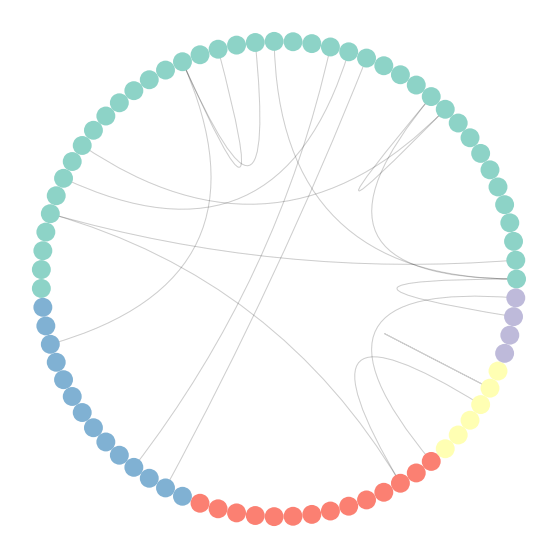

In [14]:
plt.figure(figsize=(10,10))
nv.circos(G, node_color_by='Lobe')

## Sort the nodes

In [15]:
for label, sort_index in label_to_sort_index.items():
    G.nodes[label]['sort_index'] = sort_index

<AxesSubplot:>

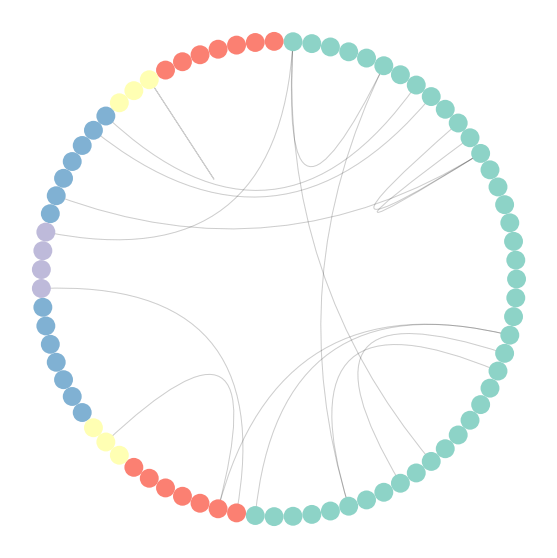

In [16]:
plt.figure(figsize=(10,10))
nv.circos(G,
          sort_by='sort_index',
          node_color_by='Lobe',
         )
#edge_lw_by='weight_scaled',
#edge_color_by='color_group',
#node_size_by='node_size'

# Custom drawing

Labels and a few other things don't seem to work out of the box with custom groups, thus we are on our own to use low level drawing functions. Lets start.

In [17]:
import circlegraph

In [18]:
graph_label_ordering = []
last_label = None

for label in sorted_labels:
    if last_label is not None:
        if region_by_label(last_label).Hemi != region_by_label(label).Hemi:
            # Add two empty locations between Hemispheres
            graph_label_ordering.extend([None, None])
        elif region_by_label(last_label).Lobe != region_by_label(label).Lobe:
            # Add one empty location between lobes in the same hemisphere
            graph_label_ordering.extend([None])
    graph_label_ordering.append(label)
    last_label = label

# The first and last labels should also be on different hemispheres.
# Verify, and then add one position of space on each side to also guarantee two
# spaces between hemispheres here
assert graph_label_ordering[0] is not None
assert graph_label_ordering[-1] is not None
assert region_by_label(graph_label_ordering[0]).Hemi != region_by_label(graph_label_ordering[-1]).Hemi
graph_label_ordering.insert(0, None)
graph_label_ordering.append(None)

Let's assign colors to each lobe-gyrus combination:

1. We will allocate a new color (from a color cycle) for each lobe
2. We will use a color gradient across al Gyri from the first to last

To compute this gradient, first let's count how many Gyri we have in each lobe:

In [19]:
import collections

lobe_to_gyrus = collections.defaultdict(set)

for label, region in enumerate_regions(labels):
    lobe_to_gyrus[region.Lobe].add(region.Gyrus)

lobe_to_gyrus_count = {k: len(v) for k, v in lobe_to_gyrus.items()}

Now, let's assign colors to each lobe-gyrus (`lg`) combination:

In [20]:
lobe_colors = {}
lg_colors = {}

color_cycle = circlegraph.colors.default_color_cycle()

last_lobe = None

# Enumerate all regions by the label order
for label, region in enumerate_regions(sorted_labels):
    lobe = region.Lobe
    gyrus = region.Gyrus
    lg = (lobe, gyrus)

    if lg in lg_colors:
        # Nothing to do, already computed
        continue

    # If we reach here, this means we have a new Gyrus in the lobe

    # Track the index of the current Gyrus in the lobe
    if lobe != last_lobe:
        if lobe not in lobe_colors:
            # Allocate the color for new lobes
            lobe_colors[lobe] = next(color_cycle)
        # Compute the gradient colors for the Gyri
        current_gradient = iter(circlegraph.colors.color_range(
            base_color=lobe_colors[lobe],
            count=lobe_to_gyrus_count[lobe]
        ))
        last_lobe = lobe

    # We only reach this line on a new gyrus (see above),
    # in this case allocate the next color from the gradient.
    lg_colors[lg] = next(current_gradient)

Here is the drawing code:

In [ ]:
my_dpi = 100
plt.figure(figsize=(500/my_dpi, 500/my_dpi), dpi=my_dpi)
ax = plt.gca()

graph_points = {}

pc = circlegraph.positions.NodePositionCalculator(
    total_nodes=len(graph_label_ordering),
    point_size=1,
    spacing=0,
    offset_angle=circlegraph.positions.offset_angle_for(
        point_count=len(graph_label_ordering),
        align='before_point',
        side='top'
    )
)

for label, point in zip(graph_label_ordering, circlegraph.graph.make_points(pc)):
    if label is None:
        # This is a "hole" point used for spacing
        continue
    graph_points[label] = point

for label, region in enumerate_regions(sorted_labels):
    graph_point = graph_points[label]
    color = lg_colors[(region.Lobe, region.Gyrus)]
    patch = plt.Circle(
        graph_point.xy, radius=graph_point.pc.point_radius,
        color=color, zorder=999)
    ax.add_patch(patch)

def labels_to_weight(source_label, target_label):
    global mat
    s_index = label_to_mat_index[source_label]
    t_index = label_to_mat_index[target_label]
    return mat[s_index, t_index]

# The graphing library want a pandas datatable with all the edges
# using 'source' and 'target' columns.
edge_table = pd.DataFrame([
    {'source': i_label, 'target': j_label, 'weight': labels_to_weight(i_label, j_label)}
    for i_label in labels
    for j_label in labels
    # Only keep one direction for each edge
    if i_label <= j_label
])

# Only keep edges with non-zero weight
edge_table = edge_table[edge_table['weight'] != 0]

# Paint edges red if positive weight otherwise negative
edge_table['color'] = ['red' if w > 0 else 'blue' for w in edge_table['weight']]

# This is normalized between -1 and +1
normalized_weight = edge_table['weight'] / np.max(np.abs(edge_table['weight']))

edge_table['line-width'] = (1 + np.abs(normalized_weight)) ** 1.5
edge_table['alpha'] = 5 * np.abs(normalized_weight) ** 6

node_positions = {
    label: graph_point.xy
    for label, graph_point in graph_points.items()
}

edge_patches = nv.lines.circos(
    edge_table, node_positions, edge_color=edge_table['color'],
    alpha=edge_table['alpha'], lw=edge_table['line-width'], aes_kw={"fc": "none"}
)
for patch in edge_patches:
    ax.add_patch(patch)

    
sorted_nodes = sorted(G.nodes.items(), key=lambda node : f"{node[1]['Hemi']}_{node[1]['Gyrus']}")    
gyrus_rois = []
last_node_gyrus = None
for label, node in sorted_nodes:
    if last_node_gyrus == None:
        gyrus_rois = [label]
        last_node_gyrus = f"{node['Hemi']}_{node['Gyrus'][node['Gyrus'].index(','):]}"
    elif f"{node['Hemi']}_{node['Gyrus'][node['Gyrus'].index(','):]}" == last_node_gyrus:
        gyrus_rois.append(label)
    else:
        node_to_write_on = gyrus_rois[len(gyrus_rois)//2]
        graph_points[node_to_write_on].draw_text(last_node_gyrus.strip()[3:], ax=ax, offset_radius=1, fontsize=6)
        gyrus_rois = [label]
        last_node_gyrus = f"{node['Hemi']}_{node['Gyrus'][node['Gyrus'].index(','):]}"
    
#for label, node in G.nodes.items():
#    graph_points[label].draw_text(node['ROIname'].strip(), ax=ax, offset_radius=1, fontsize=7)

    

    
        
pc.set_bounds(ax, padding=30)

In [22]:
sorted_nodes = sorted(G.nodes.items(), key=lambda node : f"{node[1]['Hemi']}_{node[1]['Lobe']}")    
gyrus_rois = []
last_node_gyrus = None
for label, node in sorted_nodes:
    if last_node_gyrus == None:
        gyrus_rois = [label]
        last_node_gyrus = f"{node['Hemi']}_{node['Lobe']}"
    elif f"{node['Hemi']}_{node['Lobe']}" == last_node_gyrus:
        gyrus_rois.append(label)
    else:
        node_to_write_on = gyrus_rois[len(gyrus_rois)//2]
        graph_points[node_to_write_on].draw_text(last_node_gyrus.strip(), ax=ax, offset_radius=1, fontsize=10)
        gyrus_rois = [label]
        last_node_gyrus = f"{node['Hemi']}_{node['Lobe']}"

In [23]:
sorted_nodes = sorted(G.nodes.items(), key=lambda node : f"{node[1]['Hemi']}_{node[1]['Gyrus']}")    
gyrus_rois = []
last_node_gyrus = None
for label, node in sorted_nodes:
    if last_node_gyrus == None:
        gyrus_rois = [label]
        last_node_gyrus = f"{node['Hemi']}_{node['Gyrus'][node['Gyrus'].index(','):]}"
    elif f"{node['Hemi']}_{node['Gyrus'][node['Gyrus'].index(','):]}" == last_node_gyrus:
        gyrus_rois.append(label)
    else:
        node_to_write_on = gyrus_rois[len(gyrus_rois)//2]
        graph_points[node_to_write_on].draw_text(last_node_gyrus.strip(), ax=ax, offset_radius=1, fontsize=8)
        gyrus_rois = [label]
        last_node_gyrus = f"{node['Hemi']}_{node['Gyrus'][node['Gyrus'].index(','):]}"
    